In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import stats
import uncertainties as unc
import uncertainties.unumpy as unp


df = pd.read_excel('Raddam_Data.xlsx')

# Function for Finding D Constant and Uncertainty in D

In [2]:
def Find_D_with_Error(df,dose_rate=20800,PE='Bi207AveragePE',err=0.05): # put dose_rate in rad/h, err in percentage

    if PE == "Bi207AveragePE":
        refPE = np.mean([15.17,15.26,16.06,15.84]) # average of all the PEs for all reference tiles (10x10 and 7x7)
        tilesErr = np.std([15.17,15.26,16.06,15.84],ddof=1) # error on the mean #AGB
    elif PE == "PMTCurrAverage (nA)":
        refPE = np.mean([78.7733,75.8667,75.48,72.53])
        tilesErr = np.std([78.7733,75.8667,75.48,72.53],ddof=1) # error on the mean #AGB
    elif PE == "TestBeamPE":
        refPE = 49.02
    
    dRData = df[df["DoseRate (rad/h)"]==dose_rate]

    dose = np.append(np.array(dRData["Dose (Mrad)"], dtype = float),0) # the 0 point is for the reference
    sourcePE = np.append(np.array(dRData[PE], dtype = float), refPE)
    LL0 = sourcePE/refPE
    
    # assigning uncertainty to L/L0
    if PE == "TestBeamPE":
        tberr = np.array(dRData["TestBeamPEError"], dtype = float)
        tberr = np.append(tberr, 0)
        fracerr = tberr/sourcePE
        yerr = []
        for i in range(len(fracerr)):
            err = LL0[i]*np.sqrt(fracerr[0]**2 + fracerr[i]**2+0.05**2)
            yerr.append(err)
            
    else:
		tilesRelErr = tilesErr/refPE # AGB this is the relative error from making measurements on several tiles
		yerr=np.sqrt(err**2 + err**2 + tilesRelErr**2)*LL0 # for example 5% of each light yield measurement. Here y is L/L0
		# AGB: added the relative error coming measuring different tiles (from the dose=0 tiles)
		# print 'yerr = ', yerr
		
    #yerr[-1] = 1e-10    # this is the uncertainty of the first point. In principle, it should be zero.
                        # for some reason, if the error is zero, the code couldn't estimate the uncertainty for D.

#    for i in range(len(dose)):  # if dose is more than 5 Mrad, assume 500% uncertainty in light yield measurement
#        if dose[i]>5:
#            yerr[i] = np.sqrt(0.05**2 + 2**2)*LL0[i]
    i = 0        
    while i < len(dose):  # if dose is more than 5 Mrad, drop the measurement
        if dose[i]>5:
            yerr = np.delete(yerr,i)
            dose = np.delete(dose,i)
            LL0 = np.delete(LL0,i)
        i+=1
        
    def func(d,N,mu):
        return N*np.exp(-d*mu)

    fitres = curve_fit(func, dose, LL0, sigma=yerr, full_output=True, absolute_sigma=True)
    popt_N=fitres[0][0]
    popt_mu=fitres[0][1]
    
    pcov_N=np.sqrt(fitres[1][0][0])
    pcov_mu=np.sqrt(fitres[1][1][1])
    
    mu=unc.ufloat(popt_mu, pcov_mu) #AGB
    N = unc.ufloat(popt_N, pcov_N)
    #Mucon=popt
    #Muerr=(popt**2)/pcov
    D=1./mu #AGB
    #Dcon = 1/popt
    #Derr = pcov/(popt**2)
    
    # AGB
    print("The best fit function is L/L_0 = %4.2f *exp{-%4.2f * d}" % (popt_N,popt_mu))
    print("D constant is {:.3u}".format(D)) # 3 significant digits 
    print("N is %4.2f +/- %4.2f" % (popt_N,pcov_N))
    redchisq = (fitres[2]['fvec']**2).sum()/(len(fitres[2]['fvec'])-1)
    print("chi2/Ndof = %6.3f" % redchisq)
    
    ran = np.linspace(np.amin(dose),np.amax(dose),100)
    mpl.rc("font", family="sans-serif", size=20)
    plt.figure(figsize=(15,8))
    plt.plot(ran, func(ran, popt_N, popt_mu), 'r-',linewidth=2, label=u'$\mu=${:.2uP} \nD={:.2uP} \nN={:.2uP}'.format(mu,D,N))
    nom = unp.nominal_values(D) #AGB
    std = unp.std_devs(D) #AGB 
    #plt.fill_between(ran, np.exp(-ran/(nom-1*std)), np.exp(-ran/(nom+1*std)), facecolor='r',alpha=0.3,label='1$\sigma$ band of fit') # AGB 1 sigma band
    #plt.fill_between(ran, ran*np.exp(nom-2*std), ran*np.exp(nom+2*std), facecolor='r',alpha=0.2,label='2$\sigma$ band of fit') # 2 sigma band
    #plt.plot(ran,np.exp(-ran*(popt - pcov/(popt**2))),'r--') # shows the range of values for D graphically
    #plt.plot(ran,np.exp(-ran*(popt + pcov/(popt**2))),'r--')
    plt.errorbar(dose, LL0, yerr=yerr, linestyle='None', ecolor='black', marker='o',
    markerfacecolor='black', markeredgecolor='black', markersize=5.2, label='_nolegend_', capsize=5) # AGB
    plt.ylabel("$L/L_0$")
    plt.xlabel("Dose (Mrad)")
    plt.title("Dose rate {:.1f} krad/h".format(dose_rate/1000.)) #AGB
    plt.legend(loc='upper right',frameon=False, framealpha=1, numpoints=1)
    #plt.show()
    plt.savefig(PE+"_"+str(dose_rate)+".png")
    # unc: .n returns the nominal value, .s returns the stdev
    return D.n, dose_rate/1000., D.s #AGB

# Function for Plotting D Constant vs. Dose Rate (with Sigma Bands)

In [3]:
def plot_D_vs_R(doserate, Dconstant, Derror, Setup):
    def func_R(R, a, b):
        return np.sqrt(R)/(a+b*np.sqrt(R))

    fitres = optimize.curve_fit(func_R, doserate, Dconstant, sigma=Derror, p0=[0.21,0.184], 
                                full_output=True, absolute_sigma=True)
    popt=fitres[0]; pcov=fitres[1]
    # Need to use correlated errors to draw sigma bands
    a, b = unc.correlated_values(popt, pcov)
    print('Fit results: \na = {0:.3f} \nb = {1:.3f}'.format(a,b))
    redchisq = (fitres[2]['fvec']**2).sum()/(len(fitres[2]['fvec'])-len(popt))
    print("chi2/Ndof = %6.3f" % redchisq)
    #print len(fitres[2]['fvec'])
    finex=np.arange(min(doserate)*0.9,max(doserate)*1.1,0.01)

    ran = np.linspace(0.00009,101.,10000)
    
    mpl.rc("font", family="serif", size=20)
    plt.figure(figsize=(20,11))
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim([0.009,11.])
    plt.xlim([0.00009,101.])
    py = func_R(finex,a,b)
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)
    plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), 'm-.')
    plt.errorbar(doserate, Dconstant, yerr=Derror, linestyle='None', ecolor='k',fmt='ro',
                label='Tile',capsize=3)
    plt.plot(finex, func_R(finex, *popt), 'b-',linewidth=2,label=r'Fit: $y={0:.2f}x+{1:.2f}$'.format(*popt)) # fit line
    plt.fill_between(finex, nom-1*std, nom+1*std, facecolor='#696969',alpha=0.6,label='1$\sigma$ band of fit') # bands
    plt.fill_between(finex, nom-2*std, nom+2*std, facecolor='#696969',alpha=0.3,label='2$\sigma$ band of fit') # bands
    #plt.plot(0.144, 1.03, 'bo') # N2 source data
    plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Best Fit","$\sigma$ from Best Fit",
                "$2\sigma$ from Best Fit","Bi207 with "+Setup+" (Air)"])
    plt.ylabel("Dose Constant (Mrad)")
    plt.xlabel("Dose Rate (krad/h)")
    plt.show()

# Defining different sets of data to work with

In [4]:
# General conditions for every set of data
withDose = df["Dose (Mrad)"].notnull()
withDoseRate = df["DoseRate (rad/h)"].notnull()  # .notnull() gives TRUE for the indices with non-NaN values
withBi207 = df["Bi207AveragePE"].notnull()
withPMT = df["PMTCurrAverage (nA)"].notnull()

# Air data
Air = -df["Comment"].notnull() # air data has no comment in the spreadsheet

Airdf = df[(((Air & withDose) & withDoseRate) & withBi207) & withPMT]

# N2 data
N2 = df["Comment"] == "N2"
N2more = df["Comment"] == "N2; leave in N2 to study annealing" # doesn't actually matter, because dose rates 
                                                               # are missing for data with this comment

N2df = df[((((N2 | N2more) & withDose) & withDoseRate) & withBi207) & withPMT]

# Test beam data
testBeam = df["TestBeamPE"].notnull()

tbdf = df[(((testBeam & withDose) & withDoseRate) & withBi207) & Air] # test beam data only has air data

# SiPM Data

## Air Data

### Dose rate = 19.7 krad/h

The best fit function is L/L_0 = 0.98 *exp{-0.34 * d}
D constant is 2.930+/-0.331
N is 0.98 +/- 0.05
chi2/Ndof =  0.858


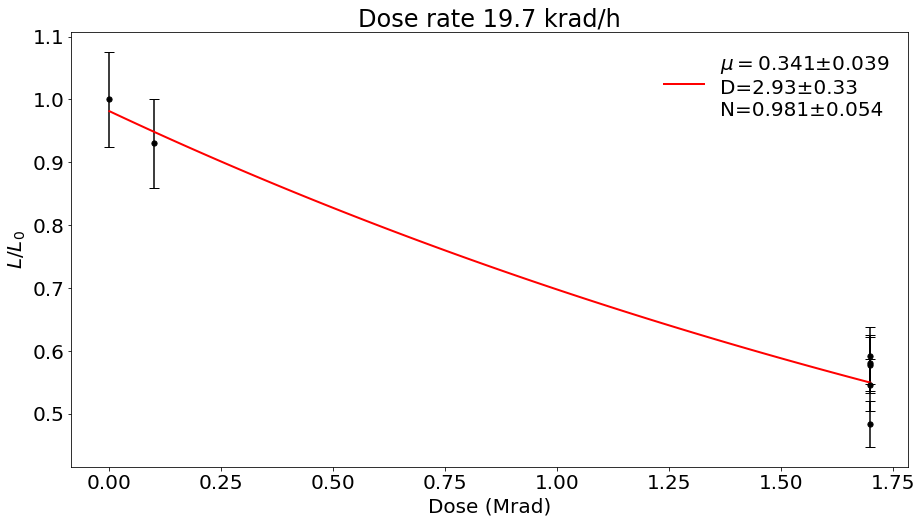

In [5]:
SA_197 = Find_D_with_Error(Airdf,19700,"Bi207AveragePE",0.05)

### Dose rate = 20.8 krad/h

The best fit function is L/L_0 = 0.88 *exp{-0.42 * d}
D constant is 2.372+/-0.305
N is 0.88 +/- 0.04
chi2/Ndof =  3.564


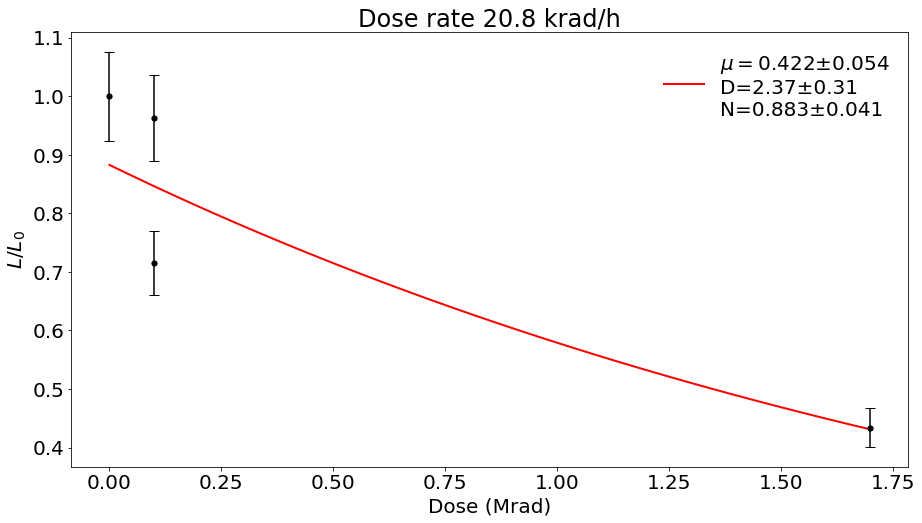

In [6]:
SA_208 = Find_D_with_Error(Airdf,20800,"Bi207AveragePE",0.05)

### Dose Rate = 0.582 krad/h

The best fit function is L/L_0 = 1.00 *exp{-0.55 * d}
D constant is 1.83+/-1.05
N is 1.00 +/- 0.08
chi2/Ndof =  0.497


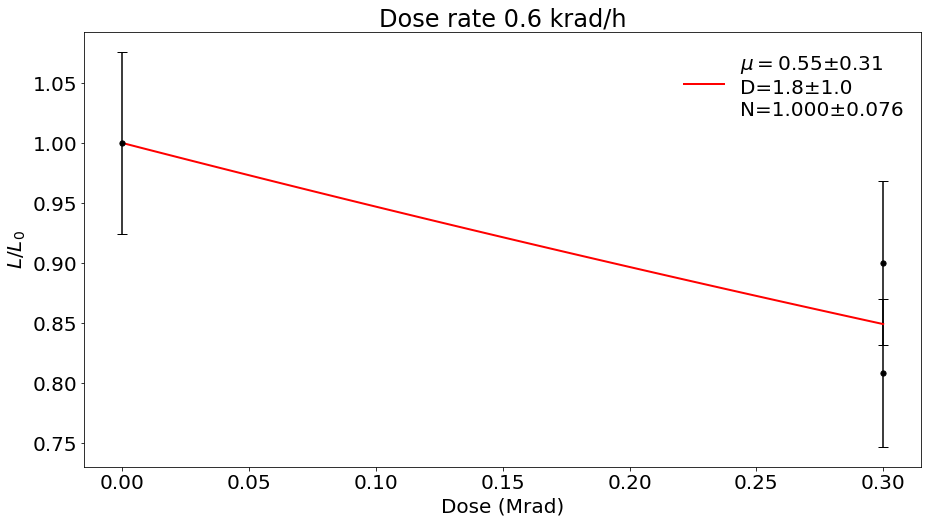

In [7]:
SA_582 = Find_D_with_Error(Airdf,582,"Bi207AveragePE",0.05)

### Dose Rate = 0.144 krad/h

The best fit function is L/L_0 = 1.00 *exp{-1.15 * d}
D constant is 0.870+/-0.705
N is 1.00 +/- 0.08
chi2/Ndof =  0.944


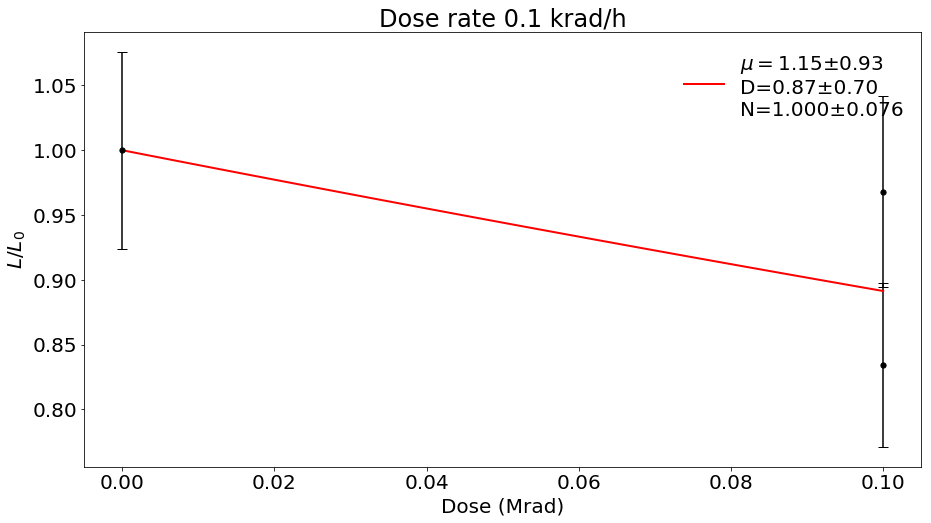

In [8]:
SA_144 = Find_D_with_Error(Airdf,144,"Bi207AveragePE",0.05)

## D Constant vs. Dose Rate (Air Only)

### With Sigma Bands

Fit results: 
a = 0.246+/-0.229 
b = 0.326+/-0.062
chi2/Ndof =  0.860


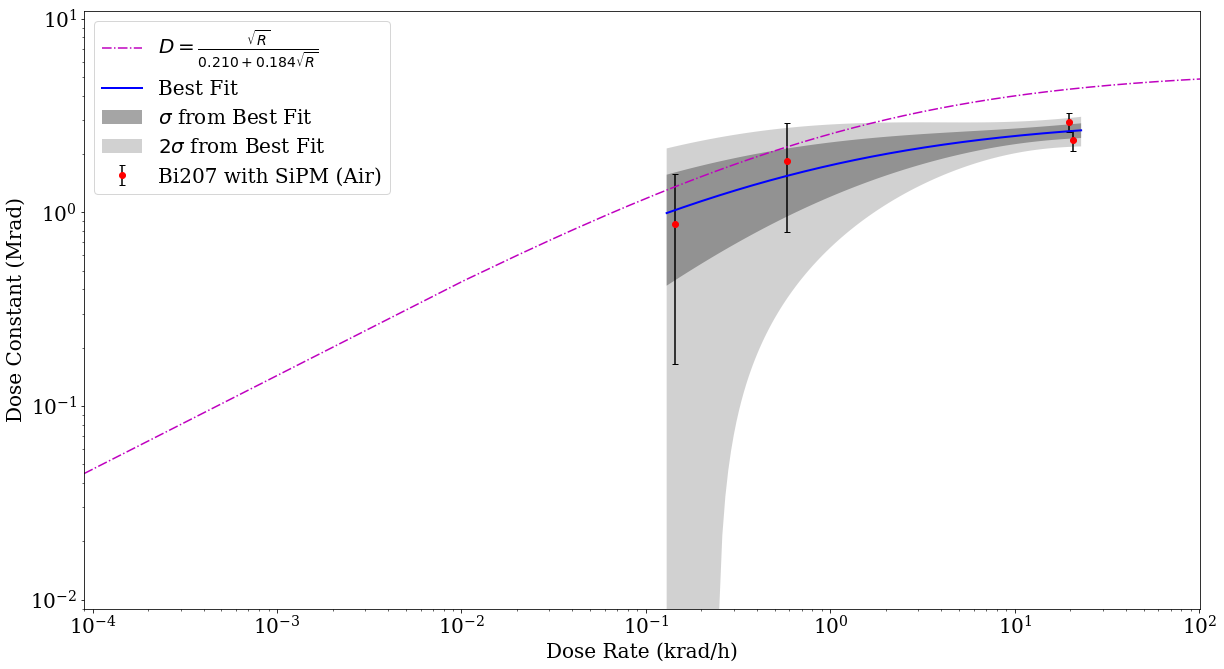

In [9]:
SA_Dconstant = [SA_208[0],SA_197[0],SA_582[0],SA_144[0]]
SA_doserate = [SA_208[1],SA_197[1],SA_582[1],SA_144[1]]
SA_error = [SA_208[2],SA_197[2],SA_582[2],SA_144[2]]

plot_D_vs_R(SA_doserate, SA_Dconstant, SA_error, "SiPM")

### No Sigma Bands

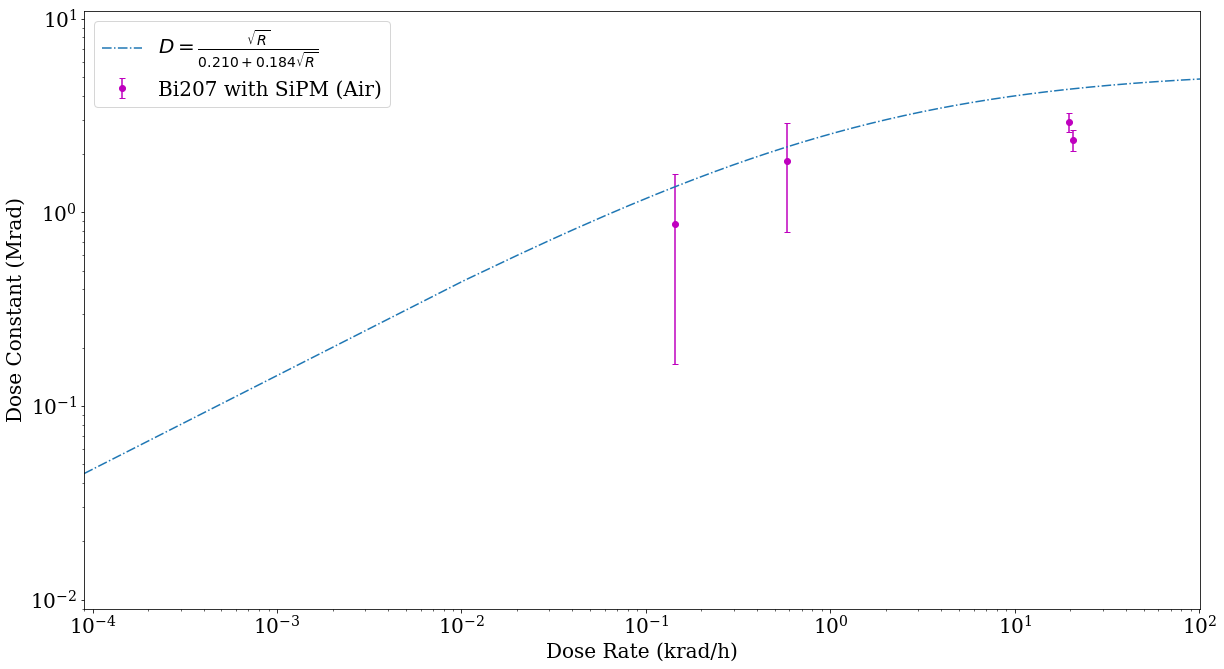

In [15]:
def func_R(R, a, b):
    return np.sqrt(R)/(a+b*np.sqrt(R))

fitres = optimize.curve_fit(func_R, SA_doserate, SA_Dconstant, sigma=SA_error, p0=[0.21,0.184], 
                            full_output=True, absolute_sigma=True)
popt=fitres[0]; pcov=fitres[1]

ran = np.linspace(0.00009,101.,10000)

mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(20,11))
plt.yscale("log")
plt.xscale("log")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])

plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.errorbar(SA_doserate, SA_Dconstant, yerr=SA_error, linestyle='None', ecolor='m',fmt='mo',
            label='Tile',capsize=3)
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)"])
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.show()

## $N_2$ Data

The best fit function is L/L_0 = 1.00 *exp{-0.66 * d}
D constant is 1.51+/-2.12
N is 1.00 +/- 0.08
chi2/Ndof =  0.011


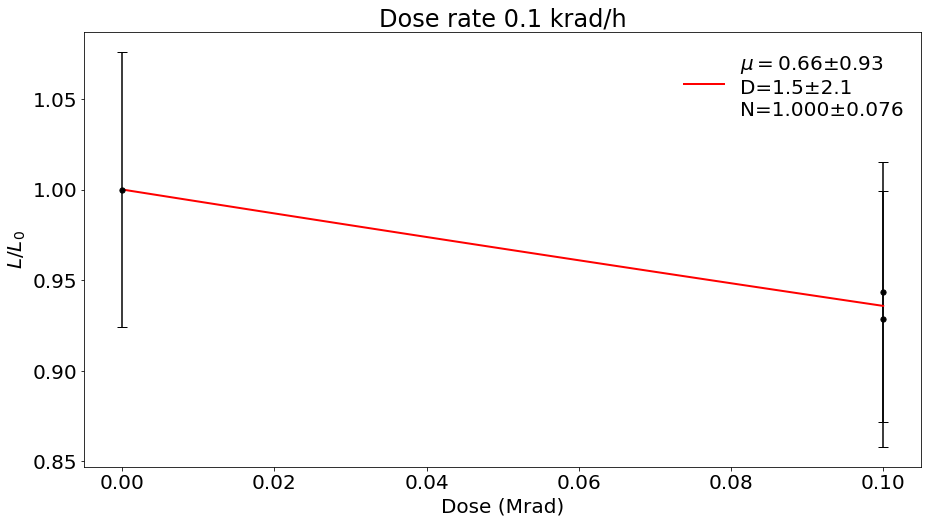

In [16]:
SN_144 = Find_D_with_Error(N2df,144,"Bi207AveragePE",0.05)

## D Constant vs. Dose Rate (Air + $N_2$)

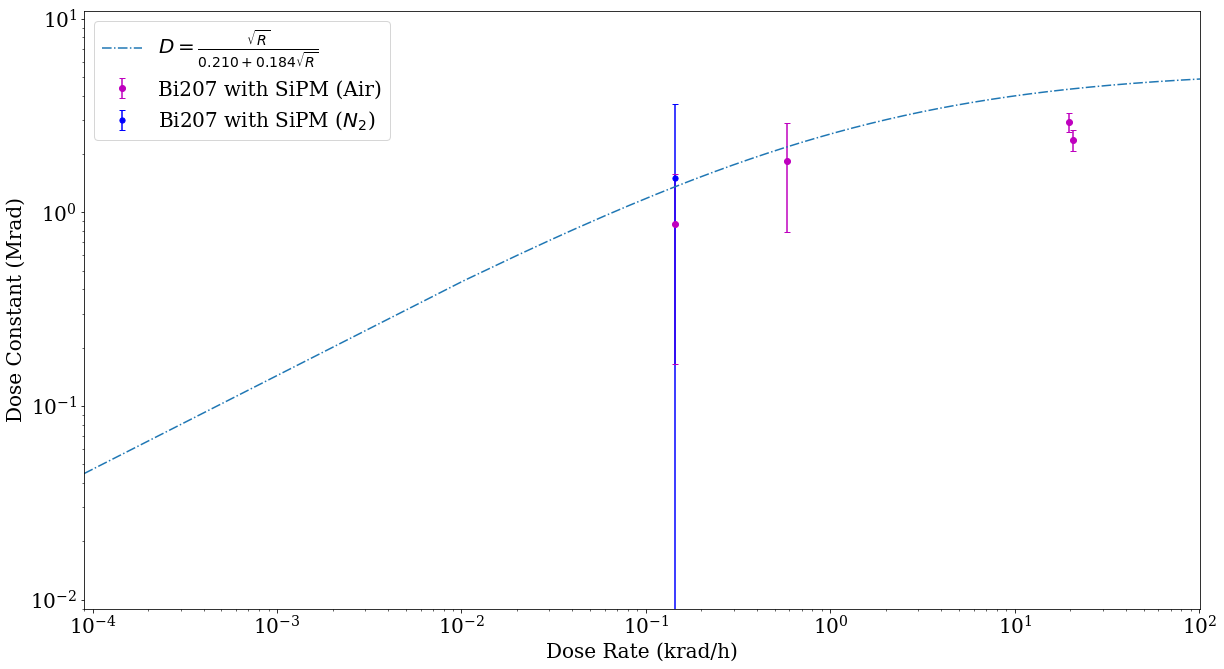

In [17]:
def func_R(R, a, b):
    return np.sqrt(R)/(a+b*np.sqrt(R))

fitres = optimize.curve_fit(func_R, SA_doserate, SA_Dconstant, sigma=SA_error, p0=[0.21,0.184], 
                            full_output=True, absolute_sigma=True)
popt=fitres[0]; pcov=fitres[1]

ran = np.linspace(0.00009,101.,10000)

mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(20,11))
plt.yscale("log")
plt.xscale("log")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])

plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.errorbar(SA_doserate, SA_Dconstant, yerr=SA_error, linestyle='None', ecolor='m',fmt='mo',
            label='Tile',capsize=3)
plt.errorbar(SN_144[1], SN_144[0], yerr=SN_144[2], linestyle='None', ecolor='b', fmt='bo',
             markersize=5.2, capsize=3) # N2 source data
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)",
           "Bi207 with SiPM ($N_2$)"])
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.show()

# PMT

## Air Data

### Dose rate = 19.7 krad/h

The best fit function is L/L_0 = 0.93 *exp{-0.62 * d}
D constant is 1.613+/-0.287
N is 0.93 +/- 0.15
chi2/Ndof =  0.934


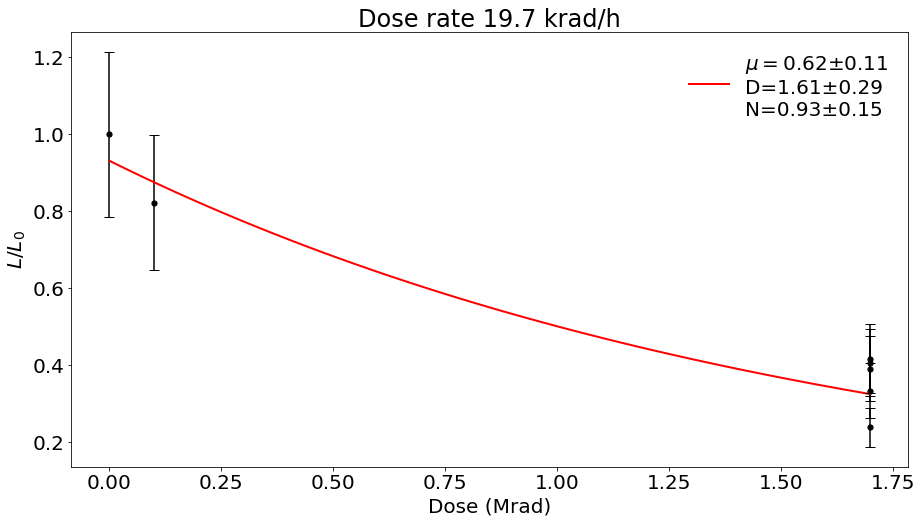

In [25]:
PA_197 = Find_D_with_Error(Airdf,19700,"PMTCurrAverage (nA)",0.15) # assuming each PMT measurement has 15% uncertainty

### Dose rate = 20.8 krad/h

The best fit function is L/L_0 = 0.79 *exp{-0.79 * d}
D constant is 1.265+/-0.248
N is 0.79 +/- 0.11
chi2/Ndof =  1.133


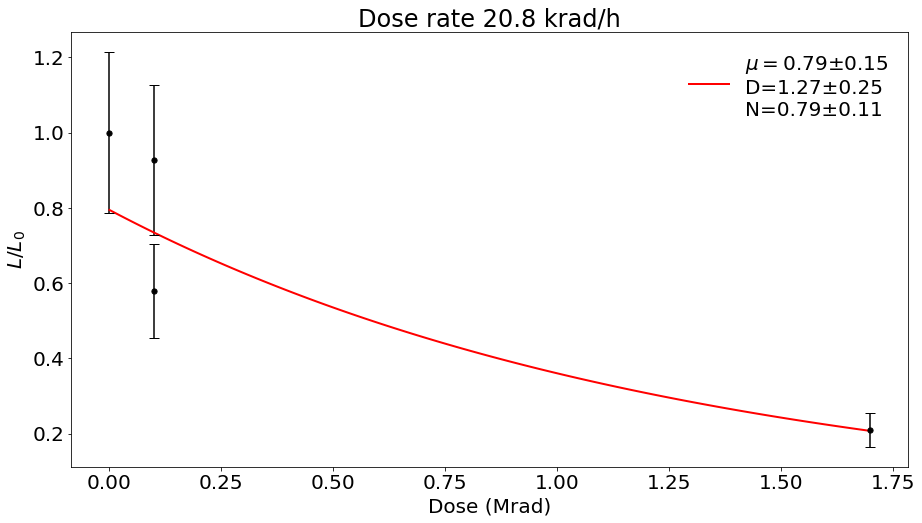

In [19]:
PA_208 = Find_D_with_Error(Airdf,20800,"PMTCurrAverage (nA)",0.15)

### Dose rate = 0.582 krad/h

The best fit function is L/L_0 = 1.00 *exp{-0.79 * d}
D constant is 1.26+/-1.39
N is 1.00 +/- 0.21
chi2/Ndof =  0.027


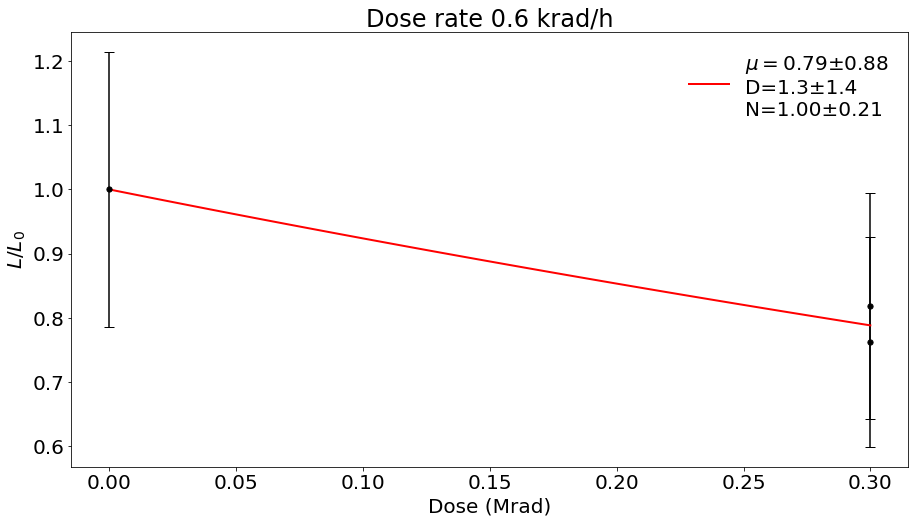

In [20]:
PA_582 = Find_D_with_Error(Airdf,582,"PMTCurrAverage (nA)",0.15)

### Dose rate = 0.144 krad/h

The best fit function is L/L_0 = 1.00 *exp{-1.97 * d}
D constant is 0.508+/-0.681
N is 1.00 +/- 0.21
chi2/Ndof =  0.205


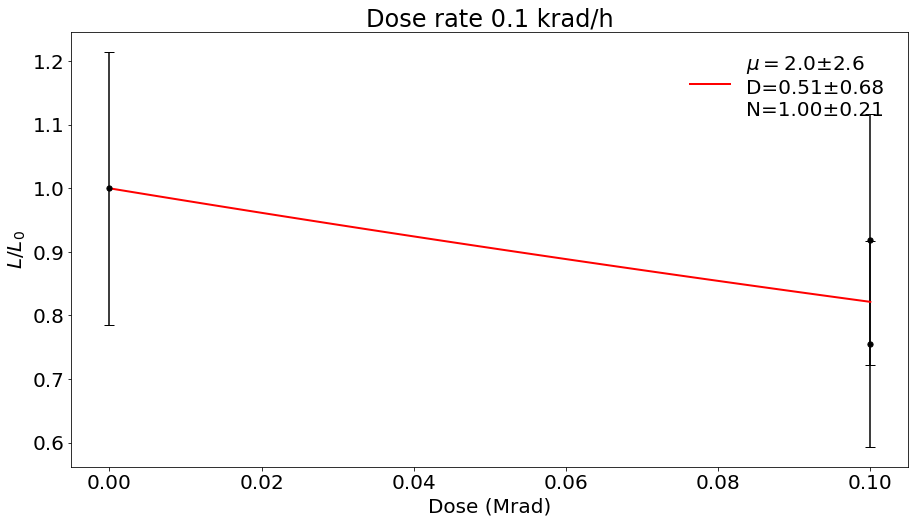

In [21]:
PA_144 = Find_D_with_Error(Airdf,144,"PMTCurrAverage (nA)",0.15)

## D Constant vs. Dose Rate (Air)

Fit results: 
a = 0.387+/-0.691 
b = 0.621+/-0.185
chi2/Ndof =  0.480


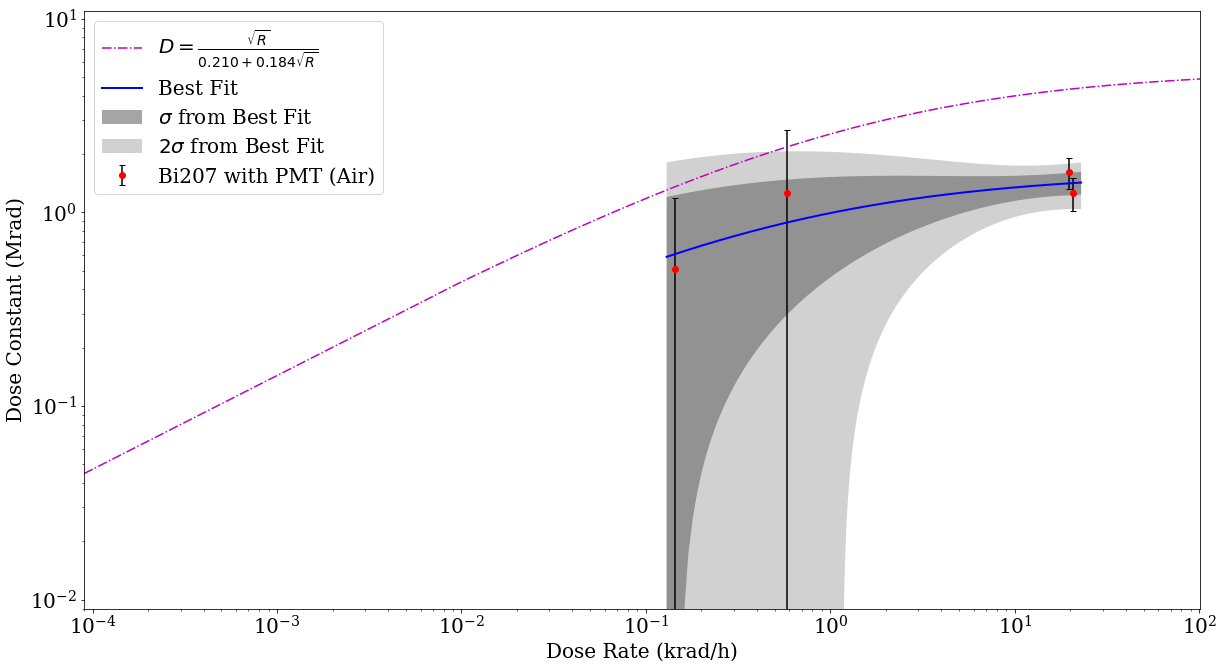

In [26]:
PA_Dconstant = [PA_208[0],PA_197[0],PA_582[0],PA_144[0]]
PA_doserate = [PA_208[1],PA_197[1],PA_582[1],PA_144[1]]
PA_error = [PA_208[2],PA_197[2],PA_582[2],PA_144[2]]

plot_D_vs_R(PA_doserate, PA_Dconstant, PA_error, "PMT")

## $N_2$ Data

The best fit function is L/L_0 = 1.00 *exp{-0.80 * d}
D constant is 1.26+/-4.15
N is 1.00 +/- 0.21
chi2/Ndof =  0.101


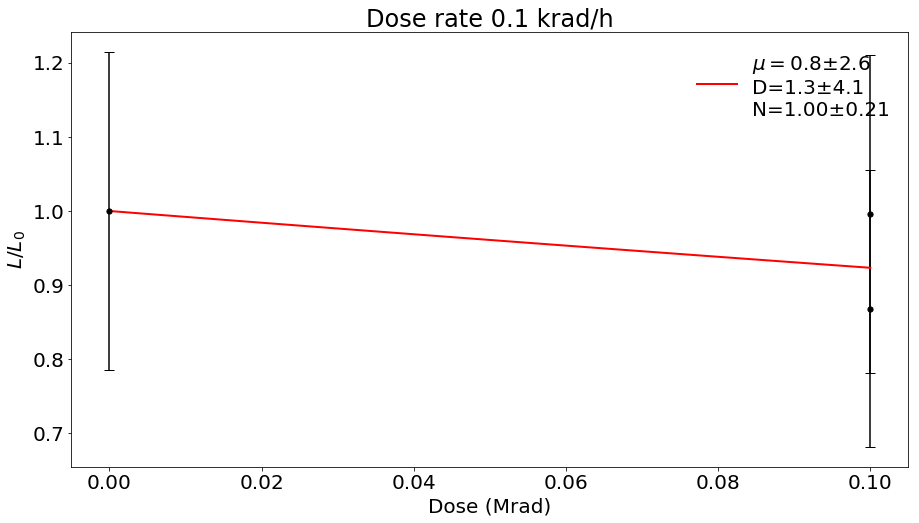

In [27]:
PN_144 = Find_D_with_Error(N2df,144,"PMTCurrAverage (nA)",0.15)

## D Constant vs. Dose Rate ($N_2$)

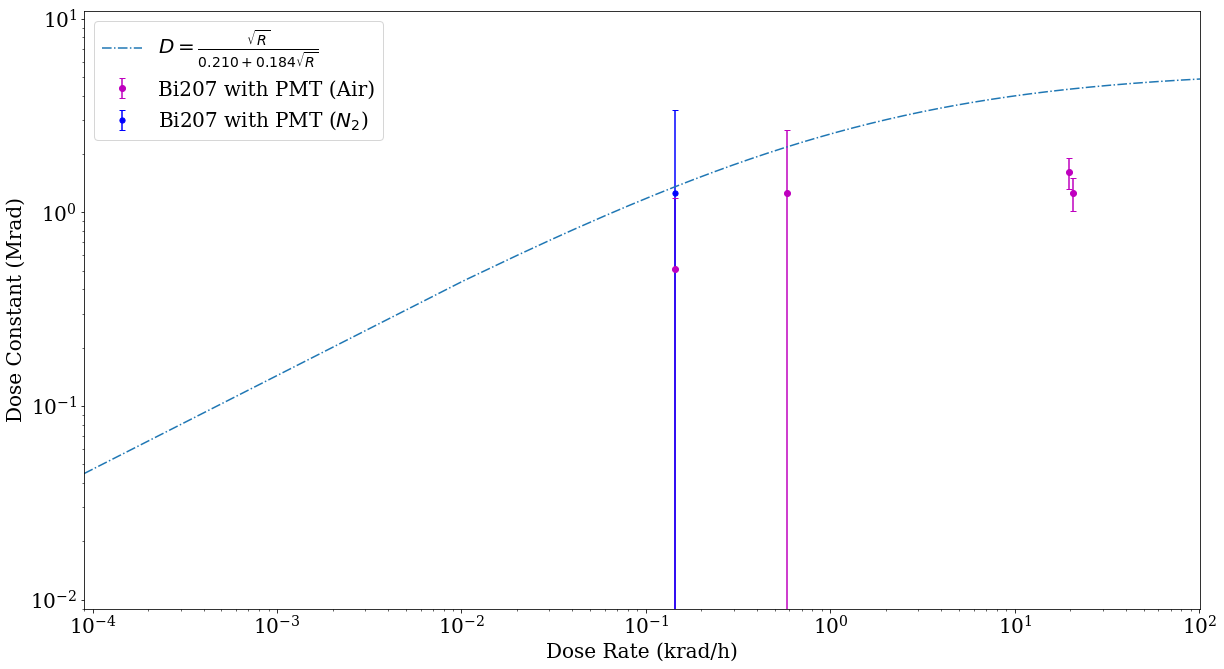

In [31]:
def func_R(R, a, b):
    return np.sqrt(R)/(a+b*np.sqrt(R))

fitres = optimize.curve_fit(func_R, PA_doserate, PA_Dconstant, sigma=PA_error, p0=[0.21,0.184], 
                            full_output=True, absolute_sigma=True)
popt=fitres[0]; pcov=fitres[1]

ran = np.linspace(0.00009,101.,10000)

mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(20,11))
plt.yscale("log")
plt.xscale("log")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])

plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.errorbar(PA_doserate, PA_Dconstant, yerr=PA_error, linestyle='None', ecolor='m',fmt='mo',
            label='Tile',capsize=3)
plt.errorbar(PN_144[1], PN_144[0], yerr=SN_144[2], linestyle='None', ecolor='b', fmt='bo',
             markersize=5.2, capsize=3) # N2 source data
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with PMT (Air)",
           "Bi207 with PMT ($N_2$)"])
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.show()

# Test Beam Data

The best fit function is L/L_0 = 0.96 *exp{-0.89 * d}
D constant is 1.1196+/-0.0494
N is 0.96 +/- 0.04
chi2/Ndof =  0.547


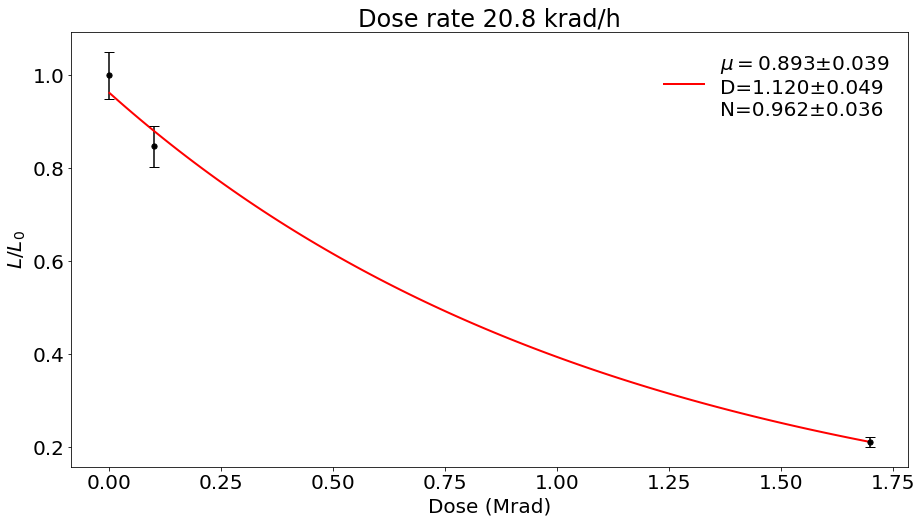

In [32]:
TA_208 = Find_D_with_Error(tbdf,20800,"TestBeamPE",0)

 # Putting Everything Together

## D vs. R with Error Bars

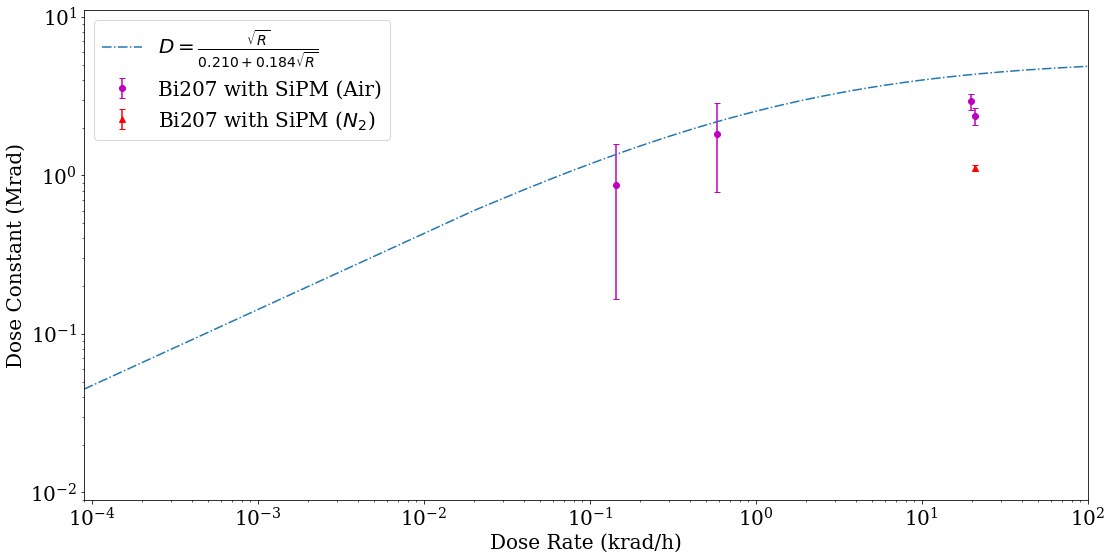

In [33]:
ran = np.linspace(0.00009,101.,5000)
mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(18,9))
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])
plt.errorbar(SA_doserate, SA_Dconstant, yerr=SA_error, linestyle='None', fmt='mo', ecolor='m',
             markersize=6, capsize=3) # SiPM Air
#plt.errorbar(SN_144[1], SN_144[0], yerr=SN_144[2], linestyle='None', fmt='bo', ecolor='b',
#             markersize=6, capsize=3) # SiPM N2
#plt.errorbar(PA_doserate, PA_Dconstant, yerr=PA_error, linestyle='None', fmt='y*', ecolor='y',
#             markersize=8, capsize=3) # PMT Air
#plt.errorbar(PN_144[1], PN_144[0], yerr=PN_144[2], linestyle='None', fmt='k*', ecolor='k',
#             markersize=8, capsize=3) # PMT N2
plt.errorbar(TA_208[1], TA_208[0], yerr=TA_208[2], linestyle='None', fmt='r^', ecolor='r',
             markersize=6, capsize=3) # Test Beam Air
plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)","Bi207 with SiPM ($N_2$)","Test Beam Data (Air)",
            "Bi207 with PMT (Air)","Bi207 with PMT ($N_2$)"])
plt.show()

## D vs. R without Error Bars

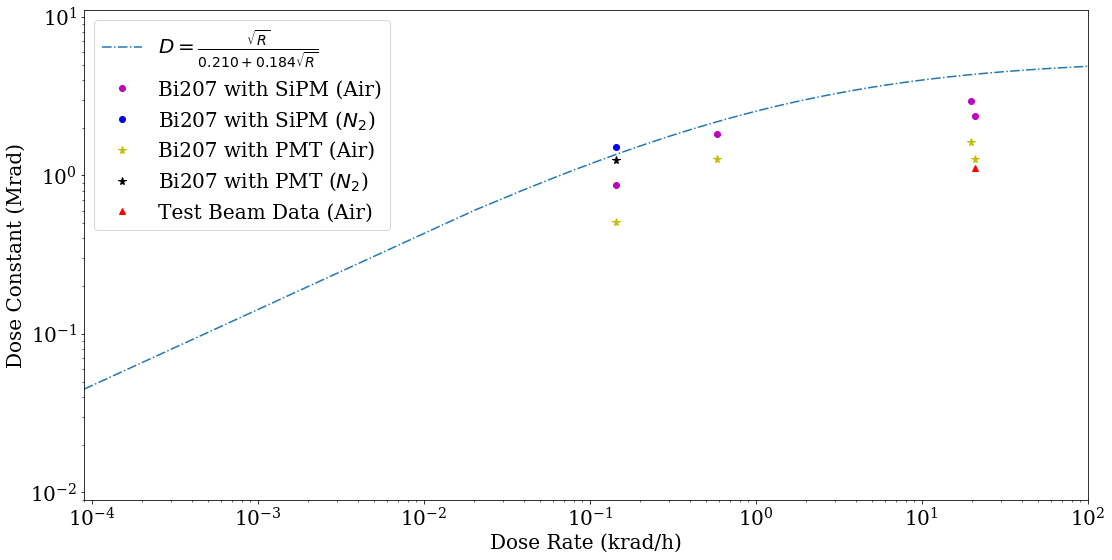

In [34]:
ran = np.linspace(0.00009,101.,5000)
mpl.rc("font", family="serif", size=20)
plt.figure(figsize=(18,9))
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Dose Constant (Mrad)")
plt.xlabel("Dose Rate (krad/h)")
plt.ylim([0.009,11.])
plt.xlim([0.00009,101.])
plt.plot(ran, np.sqrt(ran)/(0.210 + 0.184*np.sqrt(ran)), '-.')
plt.plot(SA_doserate, SA_Dconstant, 'mo') # SiPM Air
plt.plot(SN_144[1], SN_144[0], 'bo') # SiPM N2
plt.plot(PA_doserate, PA_Dconstant, 'y*',markersize=8) # PMT Air
plt.plot(PN_144[1], PN_144[0], 'k*',markersize=8) # PMT N2
plt.plot(TA_208[1], TA_208[0], 'r^',markersize=6) # PMT N2
plt.legend(["$D = \\frac{\sqrt{R}}{0.210+0.184\sqrt{R}}$","Bi207 with SiPM (Air)","Bi207 with SiPM ($N_2$)",
            "Bi207 with PMT (Air)","Bi207 with PMT ($N_2$)","Test Beam Data (Air)"])
plt.show()